# Week 8 Acceleration algorithm /. Parameter selection

#  Loading data

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = "cuprite"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T



# Give the prediected unmixing reslut

In [3]:
def compute_unmixing_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    print('acc = ',accuracy)
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

# Using the original hypercube to unmix

# Using the color img after optimal filters set to unmix

In [4]:
opti_wavelength =  [1970., 1414. , 504., 2048., 1726.  ,856., 2384. , 698.  ,770.  ,372., 1090., 1766.]
opti_bw =  [20. ,20., 20. ,20., 20. ,20. ,20. ,20., 20., 20., 20., 20.]

# Check Noise ratio

In [7]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube

In [8]:
diff = hypercube - create_sythentic_hypercube(a_map, spectra, wavelength)

In [9]:
sqrt(mean(diff**2))

0.02687883716429609

# Mean removal algorithm

Samiliar to normalization, it has been done in our ref data set allready

In [10]:
c = sqrt(mean(hypercube**2))

In [11]:
c

0.061679618458697696

In [12]:
hypercube = hypercube/c

In [13]:
sqrt(mean(hypercube**2))

0.9999999999999997

In [14]:
hypercube_sub = hypercube[100:150,100:150]
a_map_sub = a_map[100:150,100:150]

N,M,P = hypercube_sub.shape

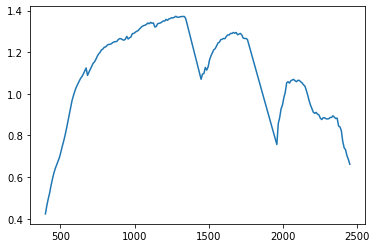

In [15]:
plt.plot(wavelength,hypercube_sub[10,10])

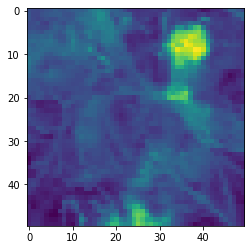

In [16]:
imshow(hypercube_sub [:,:,100])

# Now, take Sobel operator to detect discontinuities in the gradient

Too heavy computational work, crop it 

In [17]:
def sobel(img, threshold):
    '''
    edge detection based on sobel
    threshold (0,1)
    '''
    G_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    G_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    for i in range(0, rows - 2):
        for j in range(0, columns - 2):
            v = sum(sum(G_x * img[i:i+3, j:j+3]))  # vertical
            h = sum(sum(G_y * img[i:i+3, j:j+3]))  # horizon
            mag[i+1, j+1] = np.sqrt((v ** 2) + (h ** 2))
            
    for p in range(0, rows):
        for q in range(0, columns):
            if mag[p, q] < threshold:
                mag[p, q] = 1
    return mag

In [22]:
sober_img = np.zeros(hypercube_sub.shape)

for i in range(hypercube.shape[2]):
    sober_img[:,:,i] = sobel(hypercube_sub[:,:,i], 0.4)

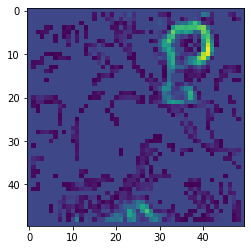

In [23]:
imshow(sober_img [:,:,100])

# dirty tiles

In [24]:
def tiles (img, t, u):
    '''
    t = tile_size
    u: percentage_of_edge_pixels
    '''
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    sub_area = np.zeros((t,t))      
    for p in range(0, rows):
        for q in range(0, columns):
            sub_area = img[p:p+t,q:q+t]
            area_sum = sum(sub_area)
            if area_sum > t*t*u:
                mag[p, q] = 1
    return mag

In [25]:
tiles_img = np.zeros(hypercube_sub.shape)

for i in range(hypercube.shape[2]):
    tiles_img[:,:,i] = tiles(sober_img[:,:,i],2,1)

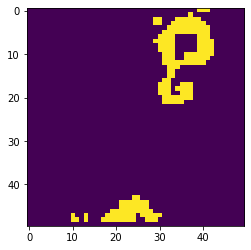

In [26]:
imshow(tiles_img [:,:,100])

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]

figure(1)
imshow(sober_img [:,:,100])
title('sober')

figure(2)
imshow(tiles_img [:,:,100])
title('dirty tiles')

figure(3)
imshow(hypercube_sub [:,:,100])
title('hypercube')


# Now use the pre-procesing hypercube to get the unmixing result 

In [27]:
predicted_origin = abundance_maps.amaps.NNLS(hypercube_sub.reshape(N*M,P), spectra) # (N*M x P)
accuracy_origin = sqrt(mean((a_map_sub.reshape((N*M,len(spectra)))-predicted_origin)**2))

predicted_sober = abundance_maps.amaps.NNLS(sober_img.reshape(N*M,P), spectra) # (N*M x P)
accuracy_sober = sqrt(mean((a_map_sub.reshape((N*M,len(spectra)))-predicted_sober)**2))


predicted_tiles = abundance_maps.amaps.NNLS(tiles_img.reshape(N*M,P), spectra) # (N*M x P)
accuracy_tiles = sqrt(mean((a_map_sub.reshape((N*M,len(spectra)))-predicted_tiles)**2))

In [28]:
print(accuracy_origin,accuracy_sober,accuracy_tiles)

0.2962620423189117 0.38834201124269013 0.09281586919085719


In [29]:
import time

In [30]:
start = time.time()
acc1,map1 = compute_unmixing_accuracy(hypercube_sub, a_map_sub, spectra, wavelength, opti_wavelength, opti_bw, return_predicted=True)
end = time.time()
print(end-start)

acc =  0.30548806947473756
0.0749821662902832


Using sober hypercube into filter image to unmxix

In [31]:
start = time.time()
acc2,map2 = compute_unmixing_accuracy(sober_img, a_map_sub, spectra, wavelength, opti_wavelength, opti_bw, return_predicted=True)
end = time.time()
print(end-start)

acc =  0.3623994067890455
0.05184483528137207


Using tiles hypercube into filter image to unmxix

In [32]:
start = time.time()
acc3,map3 = compute_unmixing_accuracy(tiles_img, a_map_sub, spectra, wavelength, opti_wavelength, opti_bw, return_predicted=True)
end = time.time()
print(end-start)

acc =  0.08714786911079143
0.04587888717651367
